/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also

train Loss: 0.2990 Acc: 0.9057
validation Loss: 0.0379 Acc: 0.9873
train Loss: 0.1263 Acc: 0.9603
validation Loss: 0.0087 Acc: 0.9973
train Loss: 0.0950 Acc: 0.9697
validation Loss: 0.0108 Acc: 0.9963
train Loss: 0.0756 Acc: 0.9757
validation Loss: 0.0074 Acc: 0.9977
train Loss: 0.0760 Acc: 0.9752
validation Loss: 0.0093 Acc: 0.9960
train Loss: 0.0684 Acc: 0.9790
validation Loss: 0.0199 Acc: 0.9937
train Loss: 0.0635 Acc: 0.9805
validation Loss: 0.0037 Acc: 0.9990
train Loss: 0.0560 Acc: 0.9831
validation Loss: 0.0048 Acc: 0.9987
train Loss: 0.0513 Acc: 0.9830
validation Loss: 0.0031 Acc: 0.9990
train Loss: 0.0519 Acc: 0.9826
validation Loss: 0.0057 Acc: 0.9977
Training finished!


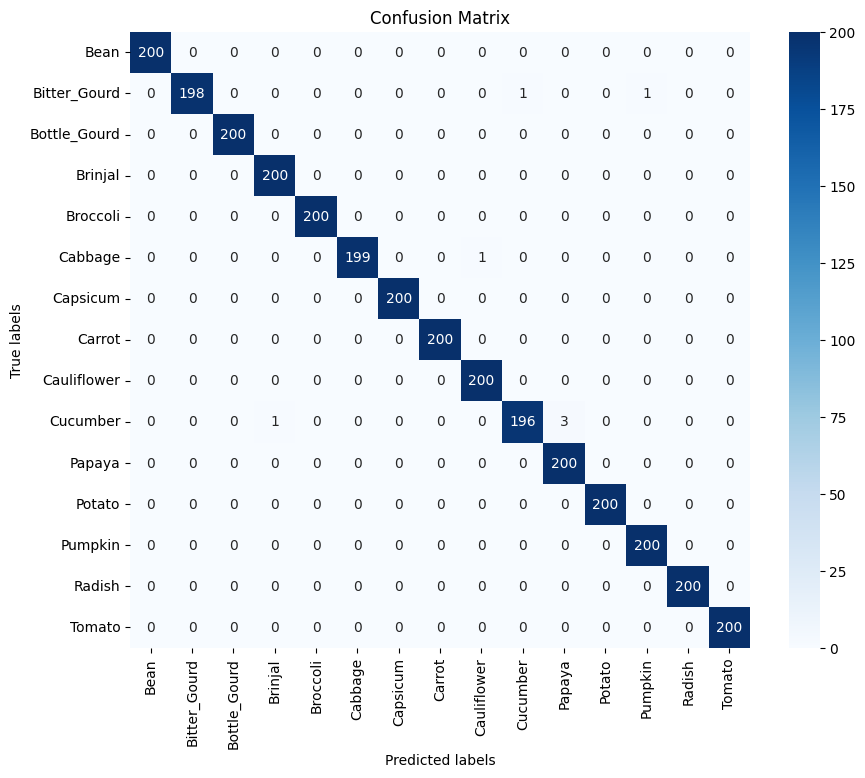

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Specify data directory
data_dir = '/content/drive/My Drive/Vegetable Images'

# Define transforms for the dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Load datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

# Define dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'validation', 'test']}

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define AlexNet model
model = models.alexnet(pretrained=True)

# Modify the last fully connected layer
num_classes = len(image_datasets['train'].classes)
model.classifier[6] = nn.Linear(4096, num_classes)

# Move model to GPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = corrects.double() / len(image_datasets[phase])

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training finished!")

# Evaluate the model on test set and plot confusion matrix
def test_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Test the model
y_true, y_pred = test_model(model, dataloaders['test'])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=image_datasets['test'].classes, yticklabels=image_datasets['test'].classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
